
## Visualizing Predictions of GridFM

This notebook demonstrates the state reconstruction capabilities of **GridFM-v0.2**, a graph-based neural network model for transmission grids. We focus on the IEEE case30 network, a standard benchmark with 30 buses, chosen for its compact size and suitability for visualization.

The dataset includes **1,023 load scenarios**, each representing a different operating condition of the grid. For each scenario, the model reconstructs the six key features of the power flow solution that are masked:

- Active Power Demand (MW)
- Reactive Power Demand (MVar)
- Active Power Generated (MW)
- Reactive Power Generated (MVar)
- Voltage Magnitude (p.u.)
- Voltage Angle (degrees)


In [ ]:
import sys

if "google.colab" in sys.modules:
    try:
        !git clone https://github.com/gridfm/gridfm-graphkit.git
        %cd /content/gridfm-graphkit
        !pip install .
        %cd examples/notebooks/
    except Exception as e:
        print(f"Failed to start Google Collab setup, due to {e}")

In [15]:
from gridfm_graphkit.datasets.powergrid_datamodule import LitGridDataModule
from gridfm_graphkit.io.param_handler import NestedNamespace
from gridfm_graphkit.tasks.feature_reconstruction_task import FeatureReconstructionTask
from gridfm_graphkit.utils.visualization import (
    visualize_error,
    visualize_quantity_heatmap,
)
from gridfm_graphkit.datasets.globals import PD, QD, PG, QG, VM, VA

import yaml
import torch
import numpy as np
import random

## Load YAML configuration file

In [16]:
config_path = "../config/case30_ieee_base.yaml"
with open(config_path) as f:
    config_dict = yaml.safe_load(f)

config_args = NestedNamespace(**config_dict)
torch.manual_seed(config_args.seed)
random.seed(config_args.seed)
np.random.seed(config_args.seed)

## Initialize the DataModule

In [17]:
data_module = LitGridDataModule(config_args, "../data")
data_module.setup("test")
test_loader = data_module.test_dataloader()

## Load the pre-trained model GridFM-v0.2

In [18]:
model = FeatureReconstructionTask(
    config_args, data_module.node_normalizers, data_module.edge_normalizers
)
state_dict = torch.load("../models/GridFM_v0_2.pth")
model.load_state_dict(state_dict)

<All keys matched successfully>

## Perform inference, batch size is equal to 1 for further visualization purposes

In [19]:
batch = next(iter(test_loader[0]))

model.eval()
with torch.no_grad():
    output = model(
        x=batch.x,
        pe=batch.pe,
        edge_index=batch.edge_index,
        edge_attr=batch.edge_attr,
        batch=batch.batch,
        mask=batch.mask,
    )

## Visualize Nodal Active Power Residuals 

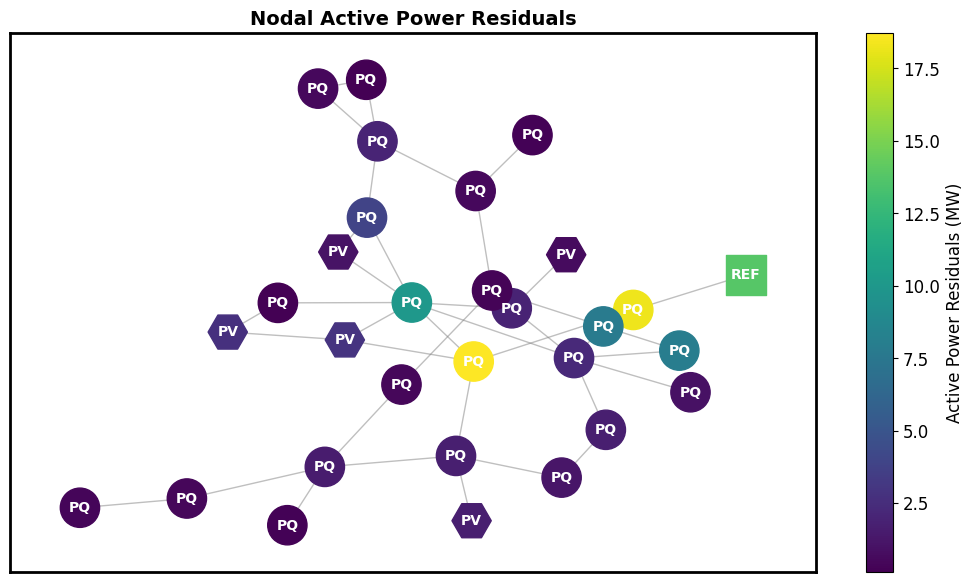

In [20]:
visualize_error(batch, output, data_module.node_normalizers[0])


## Visualize the state reconstruction capability of gridFM-v0.2 for each feature:
- Active Power Demand (MW)
- Reactive Power Demand (MVar)
- Active Power Generated (MW)
- Reactive Power Generated (MVar)
- Voltage Magnitude (p.u.)
- Voltage Angle (degrees)



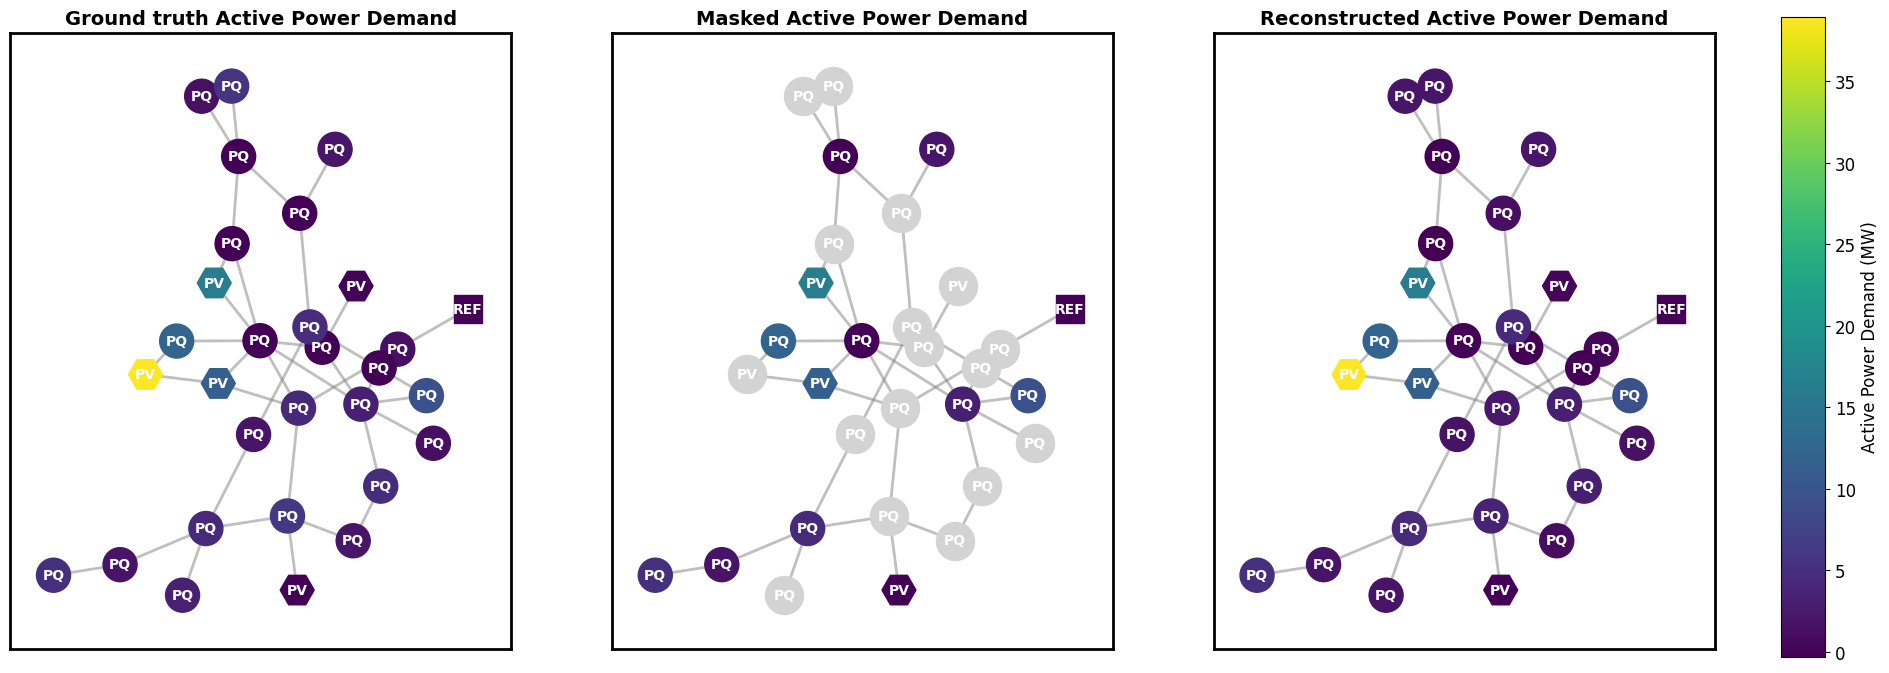

In [21]:
visualize_quantity_heatmap(
    batch,
    output,
    PD,
    "Active Power Demand",
    "MW",
    data_module.node_normalizers[0],
)

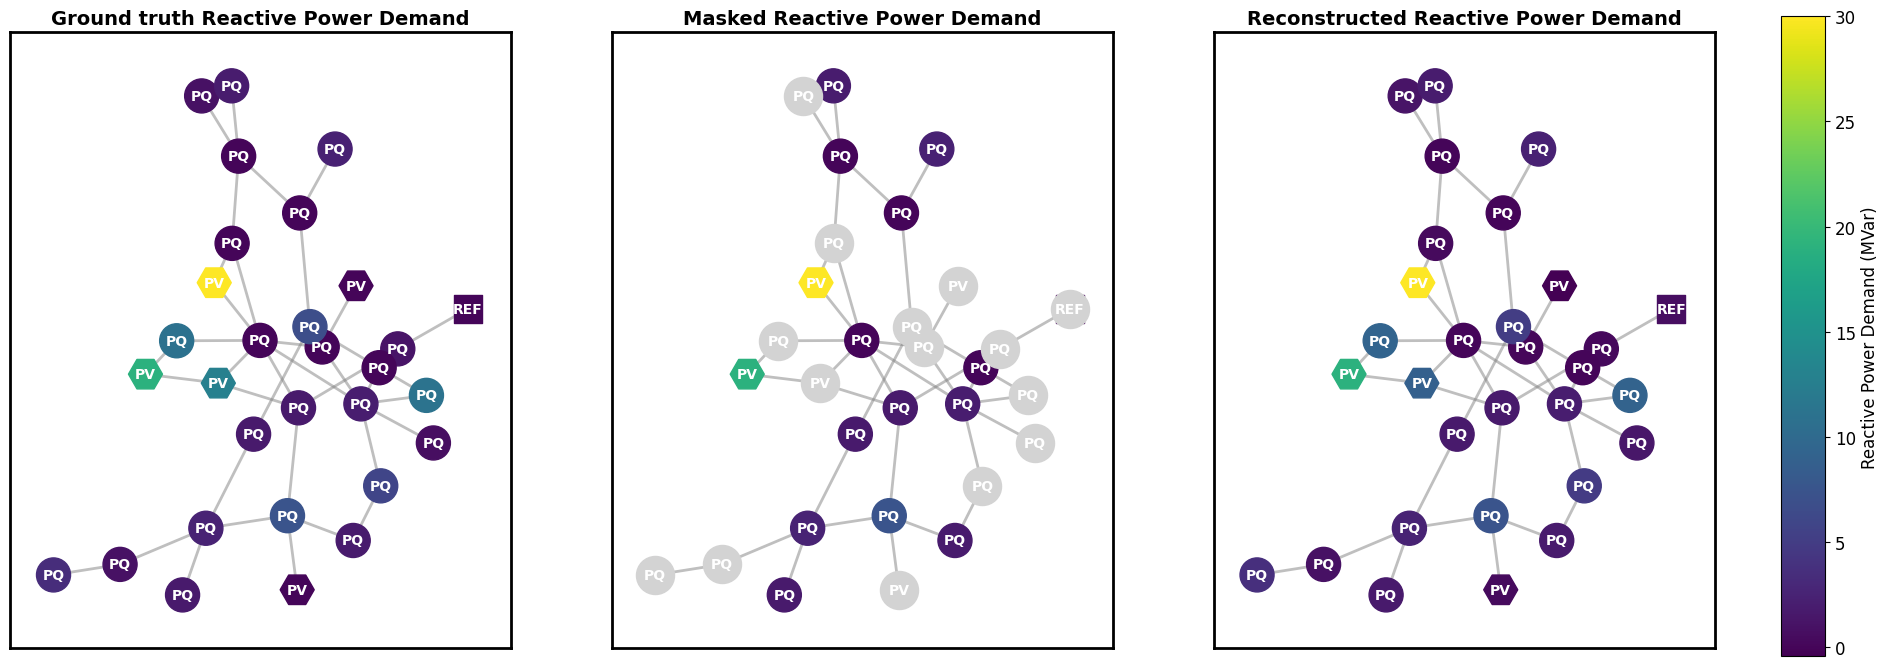

In [22]:
visualize_quantity_heatmap(
    batch,
    output,
    QD,
    "Reactive Power Demand",
    "MVar",
    data_module.node_normalizers[0],
)

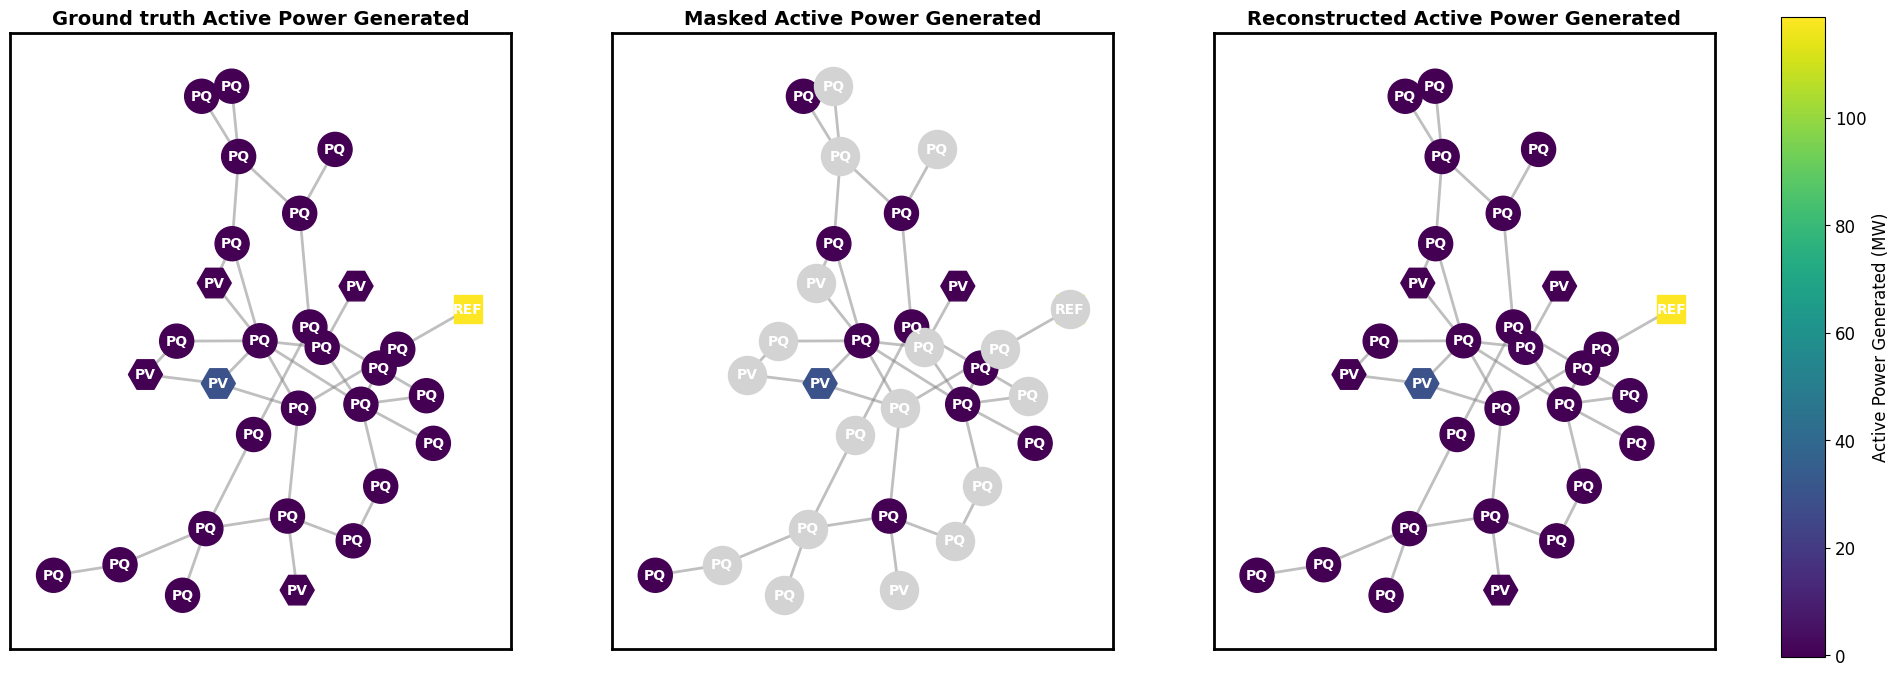

In [23]:
visualize_quantity_heatmap(
    batch,
    output,
    PG,
    "Active Power Generated",
    "MW",
    data_module.node_normalizers[0],
)

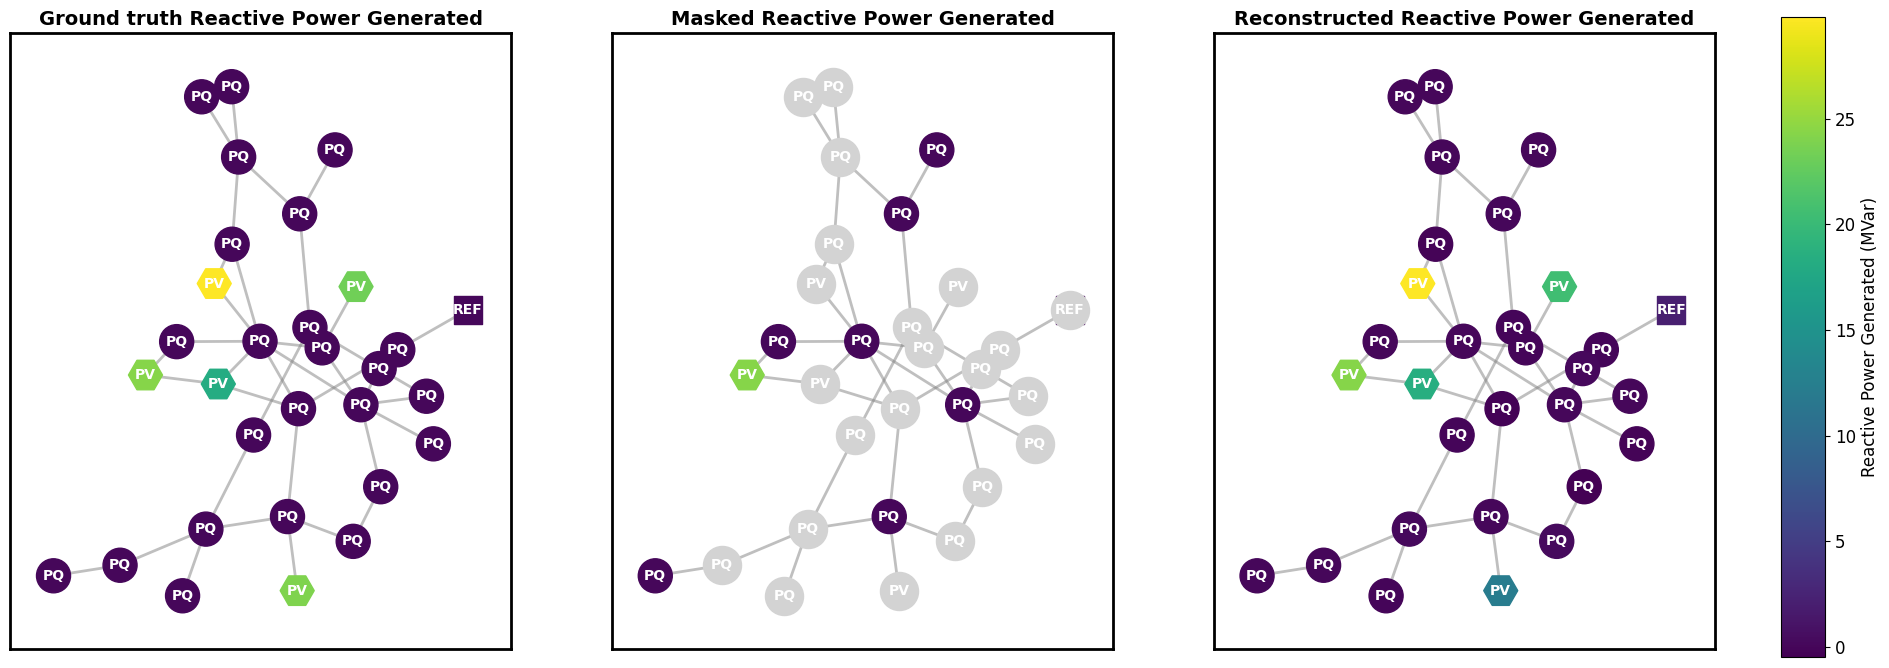

In [24]:
visualize_quantity_heatmap(
    batch,
    output,
    QG,
    "Reactive Power Generated",
    "MVar",
    data_module.node_normalizers[0],
)

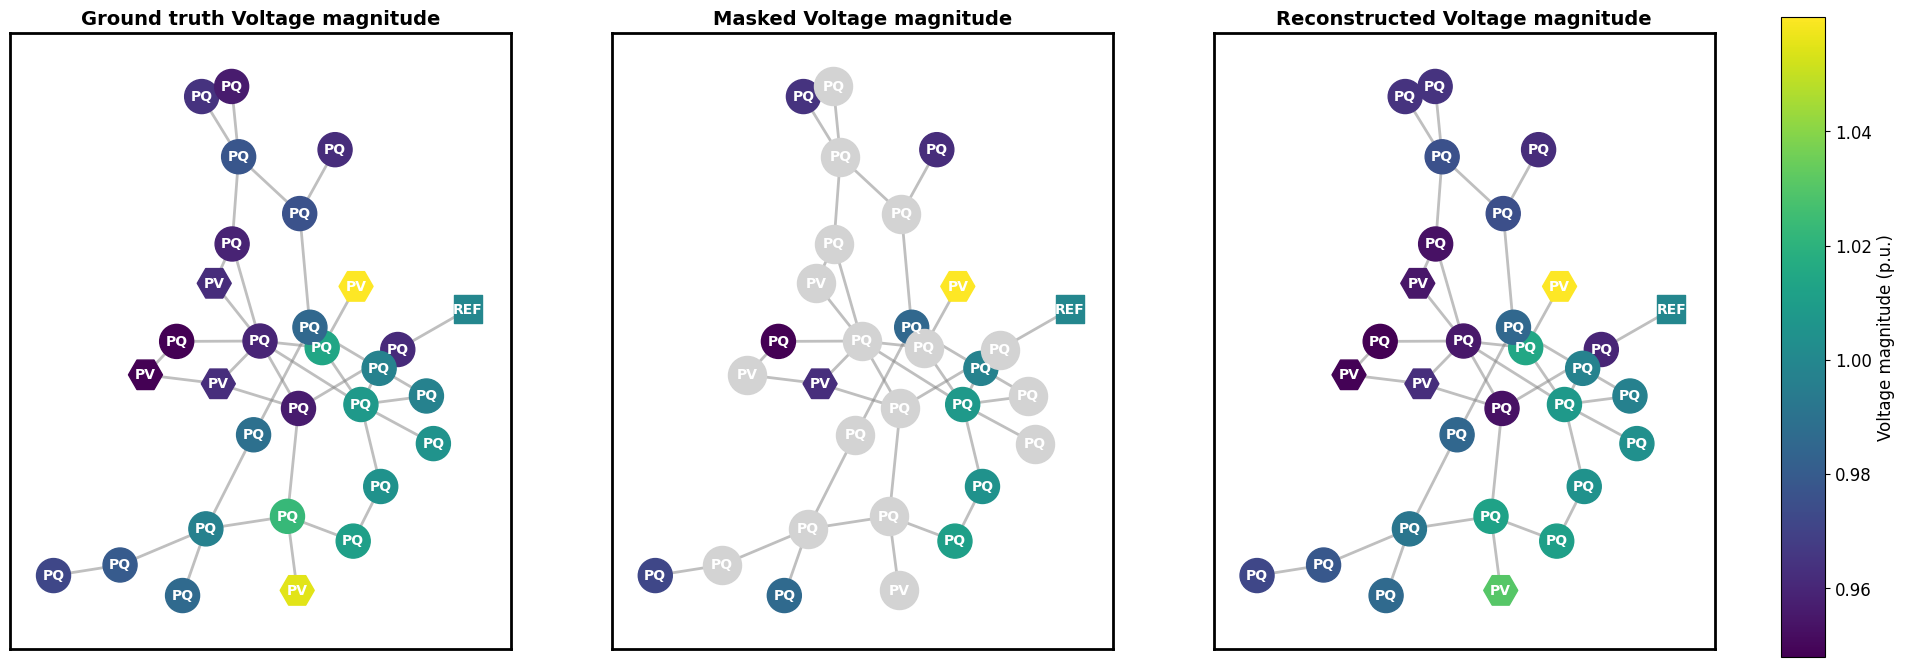

In [25]:
visualize_quantity_heatmap(
    batch,
    output,
    VM,
    "Voltage magnitude",
    "p.u.",
    data_module.node_normalizers[0],
)

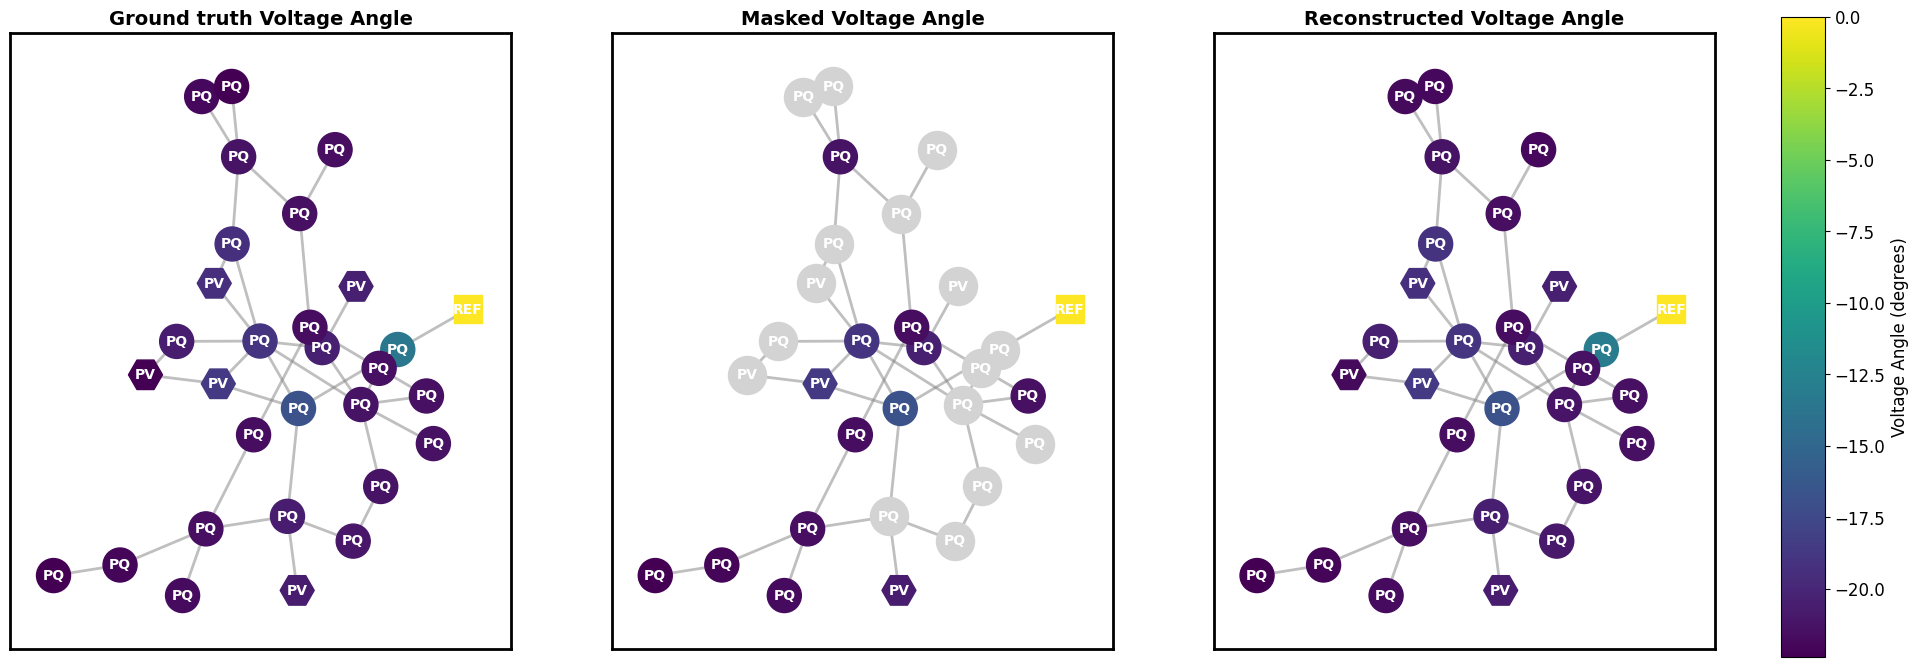

In [26]:
visualize_quantity_heatmap(
    batch,
    output,
    VA,
    "Voltage Angle",
    "degrees",
    data_module.node_normalizers[0],
)